In [1]:
import numpy as np
import random
import math
import os
import matplotlib.pyplot as plt
import pandas as pd
import glob
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
%matplotlib inline

from math import sqrt
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error

In [2]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')

In [2]:
def drop_outlier(array,count,bins):
    index = []
    range_ = np.arange(1,count,bins)
    for i in range_[:-1]:
        array_lim = array[i:i+bins]
        sigma = np.std(array_lim)
        mean = np.mean(array_lim)
        th_max,th_min = mean + sigma*2, mean - sigma*2
        idx = np.where((array_lim < th_max) & (array_lim > th_min))
        idx = idx[0] + i
        index.extend(list(idx))
    return np.array(index)

Cycled at constant current of 1°C

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']

dir_path = 'datasets/CALCE/'
Battery = {}
for name in Battary_list:
    print('Load Dataset ' + name + ' ...')
    path = glob.glob(dir_path + name + '/*.xlsx')
    dates = []
    for p in path:
        df = pd.read_excel(p, sheetname=1)
        print('Load ' + str(p) + ' ...')
        dates.append(df['Date_Time'][0])
    idx = np.argsort(dates)
    path_sorted = np.array(path)[idx]
    
    count = 0
    discharge_capacities = []
    health_indicator = []
    internal_resistance = []
    CCCT = []
    CVCT = []
    for p in path_sorted:
        df = pd.read_excel(p,sheetname=1)
        print('Load ' + str(p) + ' ...')
        cycles = list(set(df['Cycle_Index']))
        for c in cycles:
            df_lim = df[df['Cycle_Index'] == c]
            #Charging
            df_c = df_lim[(df_lim['Step_Index'] == 2)|(df_lim['Step_Index'] == 4)]
            c_v = df_c['Voltage(V)']
            c_c = df_c['Current(A)']
            c_t = df_c['Test_Time(s)']
            #CC or CV
            df_cc = df_lim[df_lim['Step_Index'] == 2]
            df_cv = df_lim[df_lim['Step_Index'] == 4]
            CCCT.append(np.max(df_cc['Test_Time(s)'])-np.min(df_cc['Test_Time(s)']))
            CVCT.append(np.max(df_cv['Test_Time(s)'])-np.min(df_cv['Test_Time(s)']))

            #Discharging
            df_d = df_lim[df_lim['Step_Index'] == 7]
            d_v = df_d['Voltage(V)']
            d_c = df_d['Current(A)']
            d_t = df_d['Test_Time(s)']
            d_im = df_d['Internal_Resistance(Ohm)']

            if(len(list(d_c)) != 0):
                time_diff = np.diff(list(d_t))
                d_c = np.array(list(d_c))[1:]
                discharge_capacity = time_diff*d_c/3600 # Q = A*h
                discharge_capacity = [np.sum(discharge_capacity[:n]) for n in range(discharge_capacity.shape[0])]
                discharge_capacities.append(-1*discharge_capacity[-1])

                dec = np.abs(np.array(d_v) - 3.8)[1:]
                start = np.array(discharge_capacity)[np.argmin(dec)]
                dec = np.abs(np.array(d_v) - 3.4)[1:]
                end = np.array(discharge_capacity)[np.argmin(dec)]
                health_indicator.append(-1 * (end - start))

                internal_resistance.append(np.mean(np.array(d_im)))
                count += 1

    discharge_capacities = np.array(discharge_capacities)
    health_indicator = np.array(health_indicator)
    internal_resistance = np.array(internal_resistance)
    CCCT = np.array(CCCT)
    CVCT = np.array(CVCT)
    
    idx = drop_outlier(discharge_capacities, count, 40)
    df_result = pd.DataFrame({'cycle':np.linspace(1,idx.shape[0],idx.shape[0]),
                              'capacity':discharge_capacities[idx],
                              'SoH':health_indicator[idx],
                              'resistance':internal_resistance[idx],
                              'CCCT':CCCT[idx],
                              'CVCT':CVCT[idx]})
    Battery[name] = df_result

Load Dataset CS2_35 ...


D:\Program Files (x86)\Anaconda3\lib\site-packages\pandas\util\_decorators.py:188: FutureWarning: The `sheetname` keyword is deprecated, use `sheet_name` instead
  return func(*args, **kwargs)


Load datasets/CALCE/CS2_35\CS2_35_10_15_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_22_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_10_29_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_01_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_08_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_11_24_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_06_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_13_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_20_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_12_23_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_18_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_24_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_1_28_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_10_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_2_4_11.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_17_10.xlsx ...
Load datasets/CALCE/CS2_35\CS2_35_8_18_10.xlsx ...
Load datasets/CALCE/C

Load datasets/CALCE/CS2_38\CS2_38_10_05_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_14_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_21_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_10_28_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_01_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_08_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_15_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_22_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_11_24_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_06_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_13_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_20_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_12_23_10.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_18_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_24_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_1_28_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_10_11.xlsx ...
Load datasets/CALCE/CS2_38\CS2_38_2_4_11.xlsx ...
Load datasets/CALCE

### 如果上面的读取数据集失败，可以通过下面的方式加载已提取出来的数据

In [3]:
Battary_list = ['CS2_35', 'CS2_36', 'CS2_37', 'CS2_38']
Battery = np.load('CALCE.npy', allow_pickle=True)
Battery = Battery.item()

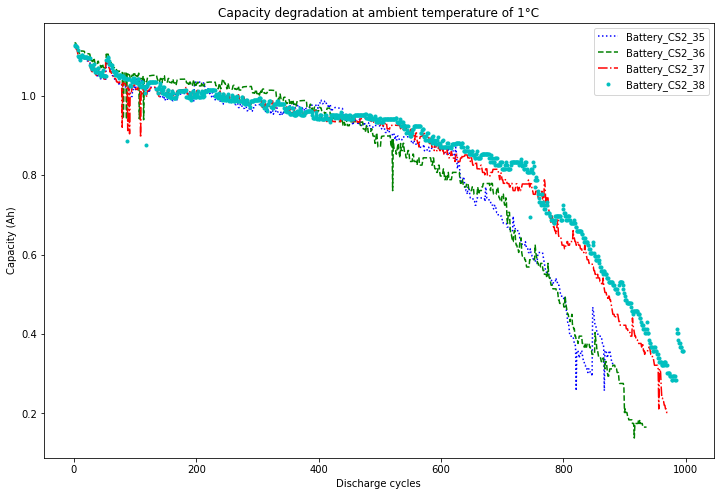

In [4]:
#Rated_Capacity = 1.1
fig, ax = plt.subplots(1, figsize=(12, 8))
color_list = ['b:', 'g--', 'r-.', 'c.']
for name,color in zip(Battary_list, color_list):
    df_result = Battery[name]
    ax.plot(df_result['cycle'], df_result['capacity'], color, label='Battery_'+name)
#plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
plt.legend()

In [5]:
def build_sequences(text, window_size):
    #text:list of capacity
    x, y = [],[]
    for i in range(len(text) - window_size):
        sequence = text[i:i+window_size]
        target = text[i+1:i+1+window_size]

        x.append(sequence)
        y.append(target)

    return np.array(x), np.array(y)


# 留一评估：一组数据为测试集，其他所有数据全部拿来训练
def get_train_test(data_dict, name, window_size=8, train_ratio=0.):
    data_sequence=data_dict[name]['capacity']
    train_data, test_data = data_sequence[:window_size+1], data_sequence[window_size+1:]
    train_x, train_y = build_sequences(text=train_data, window_size=window_size)
    for k, v in data_dict.items():
        if k != name:
            data_x, data_y = build_sequences(text=v['capacity'], window_size=window_size)
            train_x, train_y = np.r_[train_x, data_x], np.r_[train_y, data_y]
            
    return train_x, train_y, list(train_data), list(test_data)


def evaluation(y_test, y_predict):
    mae = mean_absolute_error(y_test, y_predict)
    mse = mean_squared_error(y_test, y_predict)
    rmse = sqrt(mean_squared_error(y_test, y_predict))
    return mae, rmse


def relative_error(y_test, y_predict, threshold):
    true_re, pred_re = len(y_test), 0
    for i in range(len(y_test)-1):
        if y_test[i] <= threshold >= y_test[i+1]:
            true_re = i - 1
            break
    for i in range(len(y_predict)-1):
        if y_predict[i] <= threshold:
            pred_re = i - 1
            break
    return abs(true_re - pred_re)/true_re    
    
    
def setup_seed(seed):
    np.random.seed(seed)  # Numpy module.
    random.seed(seed)  # Python random module.
    os.environ['PYTHONHASHSEED'] = str(seed) # 为了禁止hash随机化，使得实验可复现。
    torch.manual_seed(seed) # 为CPU设置随机种子
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed) # 为当前GPU设置随机种子
        torch.cuda.manual_seed_all(seed)  # if you are using multi-GPU，为所有GPU设置随机种子
        torch.backends.cudnn.benchmark = False
        torch.backends.cudnn.deterministic = True

In [6]:
class Net(nn.Module):
    def __init__(self, feature_size=8, hidden_size=[16, 8]):
        super(Net, self).__init__()
        self.feature_size, self.hidden_size = feature_size, hidden_size
        self.layer0 = nn.Linear(self.feature_size, self.hidden_size[0])
        self.layers = [nn.Sequential(nn.Linear(self.hidden_size[i], self.hidden_size[i+1]), nn.ReLU()) 
                       for i in range(len(self.hidden_size) - 1)]
        self.linear = nn.Linear(self.hidden_size[-1], 1)
 
    def forward(self, x):
        out = self.layer0(x)
        for layer in self.layers:
            out = layer(out)
        out = self.linear(out) 
        return out

# 留一评估

In [7]:
def tain(LR=0.01, feature_size=8, hidden_size=[16,8], weight_decay=0.0, window_size=8, EPOCH=1000, seed=0):
    mae_list, rmse_list, re_list = [], [], []
    result_list = []
    for i in range(4):
        name = Battary_list[i]
        train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)
        train_size = len(train_x)
        print('sample size: {}'.format(train_size))

        setup_seed(seed)
        model = Net(feature_size=feature_size, hidden_size=hidden_size)
        model = model.to(device)

        optimizer = torch.optim.Adam(model.parameters(), lr=LR, weight_decay=weight_decay)
        criterion = nn.MSELoss()

        test_x = train_data.copy()
        loss_list, y_ = [0], []
        for epoch in range(EPOCH):
            X = np.reshape(train_x/Rated_Capacity, (-1, feature_size)).astype(np.float32)
            y = np.reshape(train_y[:,-1]/Rated_Capacity,(-1,1)).astype(np.float32)

            X, y = torch.from_numpy(X).to(device), torch.from_numpy(y).to(device)
            output= model(X)
            loss = criterion(output, y)
            optimizer.zero_grad()              # clear gradients for this training step
            loss.backward()                    # backpropagation, compute gradients
            optimizer.step()                   # apply gradients

            if (epoch + 1)%100 == 0:
                test_x = train_data.copy() #每100次重新预测一次
                point_list = []
                while (len(test_x) - len(train_data)) < len(test_data):
                    x = np.reshape(np.array(test_x[-feature_size:])/Rated_Capacity, (-1, feature_size)).astype(np.float32)
                    x = torch.from_numpy(x).to(device)
                    pred = model(x) # 测试集 模型预测#pred shape为(batch_size=1, feature_size=1)
                    next_point = pred.data.numpy()[0,0] * Rated_Capacity
                    test_x.append(next_point)#测试值加入原来序列用来继续预测下一个点
                    point_list.append(next_point)#保存输出序列最后一个点的预测值
                y_.append(point_list)#保存本次预测所有的预测值
                loss_list.append(loss)
                mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
                re = relative_error(
                    y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
                print('epoch:{:<2d} | loss:{:<6.4f} | MAE:{:<6.4f} | RMSE:{:<6.4f} | RE:{:<6.4f}'.format(epoch, loss, mae, rmse, re))
            if (len(loss_list) > 1) and (abs(loss_list[-2] - loss_list[-1]) < 1e-6):
                break

        mae, rmse = evaluation(y_test=test_data, y_predict=y_[-1])
        re = relative_error(y_test=test_data, y_predict=y_[-1], threshold=Rated_Capacity*0.7)
        mae_list.append(mae)
        rmse_list.append(rmse)
        re_list.append(re)
        result_list.append(y_[-1])
    return re_list, mae_list, rmse_list, result_list

# 设置 10 个不同的随机种子，然后取均值。

In [8]:
window_size = 8
EPOCH = 1000
LR = 0.01    # learning rate
feature_size = window_size
hidden_size = [32,16]
weight_decay = 0.0
Rated_Capacity = 1.1

MAE, RMSE, RE = [], [], []
for seed in range(10):
    re_list, mae_list, rmse_list, _ = tain(LR=LR, feature_size=feature_size, hidden_size=hidden_size, weight_decay=weight_decay,
                                           window_size=window_size, EPOCH=EPOCH, seed=seed)
    RE.append(np.mean(np.array(re_list)))
    MAE.append(np.mean(np.array(mae_list)))
    RMSE.append(np.mean(np.array(rmse_list)))
    print('------------------------------------------------------------------')

print('RE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RE)), np.std(np.array(RE))))
print('MAE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(MAE)), np.std(np.array(MAE))))
print('RMSE: mean: {:<6.4f} | std: {:<6.4f}'.format(np.mean(np.array(RMSE)), np.std(np.array(RMSE))))
print('------------------------------------------------------------------')
print('------------------------------------------------------------------')

sample size: 2881
epoch:99 | loss:0.0002 | MAE:0.1863 | RMSE:0.2072 | RE:0.6413
epoch:199 | loss:0.0002 | MAE:0.0550 | RMSE:0.0661 | RE:0.1032
epoch:299 | loss:0.0002 | MAE:0.0537 | RMSE:0.0643 | RE:0.1000
epoch:399 | loss:0.0002 | MAE:0.0535 | RMSE:0.0641 | RE:0.0984
epoch:499 | loss:0.0002 | MAE:0.0533 | RMSE:0.0638 | RE:0.0984
epoch:599 | loss:0.0002 | MAE:0.0530 | RMSE:0.0634 | RE:0.0984
epoch:699 | loss:0.0002 | MAE:0.0509 | RMSE:0.0605 | RE:0.0921
epoch:799 | loss:0.0001 | MAE:0.0478 | RMSE:0.0565 | RE:0.0841
epoch:899 | loss:0.0001 | MAE:0.0476 | RMSE:0.0561 | RE:0.0825
epoch:999 | loss:0.0001 | MAE:0.0490 | RMSE:0.0580 | RE:0.0873
sample size: 2827
epoch:99 | loss:0.0003 | MAE:0.1854 | RMSE:0.2368 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0342 | RMSE:0.0416 | RE:0.0772
epoch:299 | loss:0.0002 | MAE:0.0347 | RMSE:0.0417 | RE:0.0740
epoch:399 | loss:0.0002 | MAE:0.0334 | RMSE:0.0404 | RE:0.0724
epoch:499 | loss:0.0002 | MAE:0.0324 | RMSE:0.0395 | RE:0.0693
epoch:599 | loss:0.00

epoch:999 | loss:0.0002 | MAE:0.1295 | RMSE:0.1734 | RE:0.2396
------------------------------------------------------------------
sample size: 2881
epoch:99 | loss:0.0022 | MAE:0.1618 | RMSE:0.2035 | RE:1.0000
epoch:199 | loss:0.0005 | MAE:0.1539 | RMSE:0.1967 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1250 | RMSE:0.1471 | RE:0.3619
epoch:399 | loss:0.0001 | MAE:0.0472 | RMSE:0.0546 | RE:0.0810
epoch:499 | loss:0.0001 | MAE:0.0796 | RMSE:0.1021 | RE:0.1317
sample size: 2827
epoch:99 | loss:0.0021 | MAE:0.1976 | RMSE:0.2583 | RE:1.0000
epoch:199 | loss:0.0006 | MAE:0.1911 | RMSE:0.2552 | RE:1.0000
epoch:299 | loss:0.0002 | MAE:0.1682 | RMSE:0.2197 | RE:1.0000
epoch:399 | loss:0.0001 | MAE:0.0717 | RMSE:0.0847 | RE:0.1937
epoch:499 | loss:0.0001 | MAE:0.1257 | RMSE:0.1662 | RE:0.2142
epoch:599 | loss:0.0001 | MAE:0.1830 | RMSE:0.2394 | RE:0.4047
sample size: 2791
epoch:99 | loss:0.0022 | MAE:0.1560 | RMSE:0.2038 | RE:1.0000
epoch:199 | loss:0.0005 | MAE:0.1484 | RMSE:0.1978 | RE:1.0000


epoch:199 | loss:0.0001 | MAE:0.1248 | RMSE:0.2174 | RE:1.0000
epoch:299 | loss:0.0001 | MAE:0.0830 | RMSE:0.1367 | RE:0.2508
sample size: 2827
epoch:99 | loss:0.0002 | MAE:0.7786 | RMSE:0.9941 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.1441 | RMSE:0.2373 | RE:1.0000
epoch:299 | loss:0.0001 | MAE:0.1336 | RMSE:0.2207 | RE:1.0000
epoch:399 | loss:0.0001 | MAE:0.0755 | RMSE:0.1110 | RE:0.1795
epoch:499 | loss:0.0001 | MAE:0.0590 | RMSE:0.0832 | RE:0.1276
sample size: 2791
epoch:99 | loss:0.0002 | MAE:0.1912 | RMSE:0.2359 | RE:0.4490
epoch:199 | loss:0.0002 | MAE:0.0209 | RMSE:0.0303 | RE:0.0127
epoch:299 | loss:0.0002 | MAE:0.0617 | RMSE:0.0888 | RE:0.0963
sample size: 2767
epoch:99 | loss:0.0002 | MAE:0.3071 | RMSE:0.3759 | RE:1.0000
epoch:199 | loss:0.0001 | MAE:0.0814 | RMSE:0.1324 | RE:0.1928
epoch:299 | loss:0.0001 | MAE:0.0224 | RMSE:0.0347 | RE:0.0241
------------------------------------------------------------------
sample size: 2881
epoch:99 | loss:0.0011 | MAE:0.1557 | RMSE:0.

# 查看每组电池的曲线拟合效果

sample size: 2881
epoch:99 | loss:0.0002 | MAE:0.1197 | RMSE:0.1990 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0541 | RMSE:0.0680 | RE:0.1238
epoch:299 | loss:0.0002 | MAE:0.0357 | RMSE:0.0496 | RE:0.0429
epoch:399 | loss:0.0002 | MAE:0.0332 | RMSE:0.0510 | RE:0.0143
epoch:499 | loss:0.0002 | MAE:0.0739 | RMSE:0.1258 | RE:0.2143
epoch:599 | loss:0.0002 | MAE:0.0897 | RMSE:0.1487 | RE:0.2857
epoch:699 | loss:0.0001 | MAE:0.0833 | RMSE:0.1371 | RE:0.2476
epoch:799 | loss:0.0001 | MAE:0.0854 | RMSE:0.1396 | RE:0.2540
epoch:899 | loss:0.0001 | MAE:0.0853 | RMSE:0.1385 | RE:0.2508
epoch:999 | loss:0.0001 | MAE:0.0922 | RMSE:0.1486 | RE:0.2810
sample size: 2827
epoch:99 | loss:0.0004 | MAE:0.1852 | RMSE:0.2481 | RE:1.0000
epoch:199 | loss:0.0002 | MAE:0.0731 | RMSE:0.1070 | RE:0.0819
epoch:299 | loss:0.0002 | MAE:0.0976 | RMSE:0.1334 | RE:0.1417
epoch:399 | loss:0.0002 | MAE:0.1093 | RMSE:0.1470 | RE:0.1717
epoch:499 | loss:0.0002 | MAE:0.1161 | RMSE:0.1552 | RE:0.1906
epoch:599 | loss:0.00

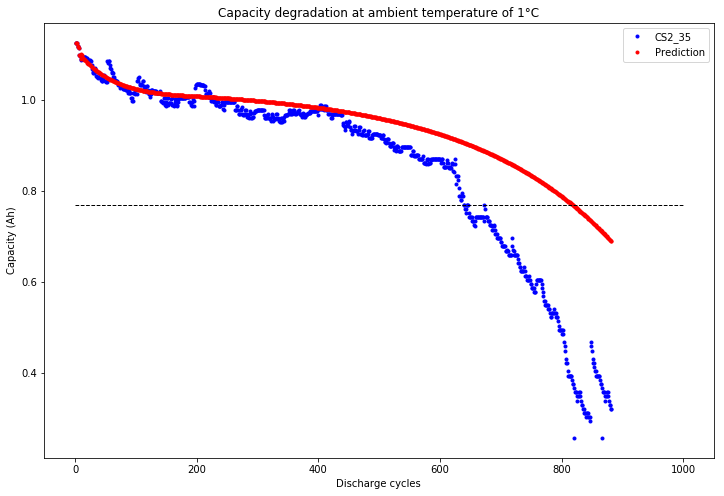

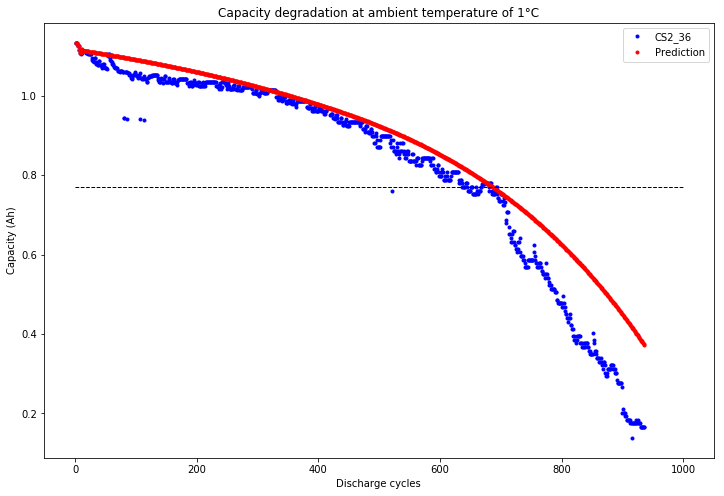

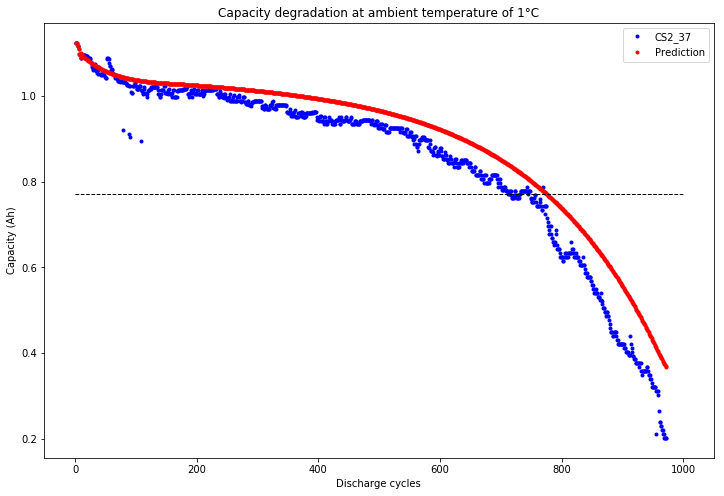

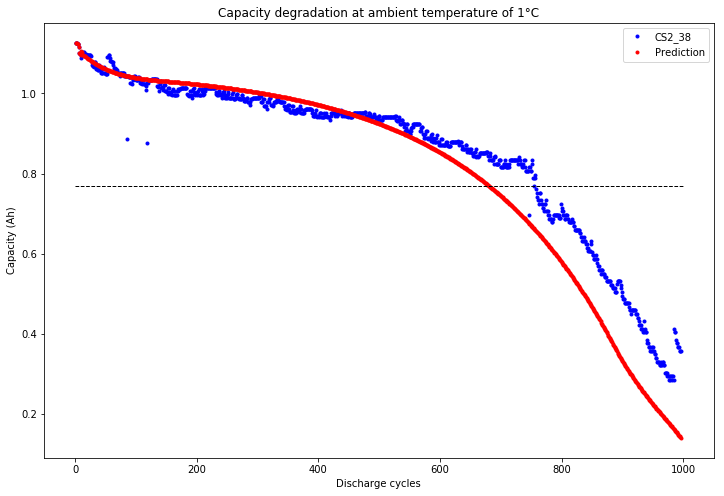

In [9]:
seed = 6
_, _, _, result_list = tain(LR=LR, feature_size=feature_size, hidden_size=hidden_size, weight_decay=weight_decay,
                            window_size=window_size, EPOCH=EPOCH, seed=seed)
for i in range(4):
    name = Battary_list[i]
    train_x, train_y, train_data, test_data = get_train_test(Battery, name, window_size)

    aa = train_data[:window_size+1].copy() # 第一个输入序列
    [aa.append(a) for a in result_list[i]] # 测试集预测结果

    battery = Battery[name]
    fig, ax = plt.subplots(1, figsize=(12, 8))
    ax.plot(battery['cycle'], battery['capacity'], 'b.', label=name)
    ax.plot(battery['cycle'], aa, 'r.', label='Prediction')
    plt.plot([-1,1000],[Rated_Capacity*0.7, Rated_Capacity*0.7], c='black', lw=1, ls='--')  # 临界点直线
    ax.set(xlabel='Discharge cycles', ylabel='Capacity (Ah)', title='Capacity degradation at ambient temperature of 1°C')
    plt.legend()